<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/cellhash/cellhash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Oct  4 19:31:13 UTC 2022


In [3]:
import sys
import os
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install -U matplotlib
  !pip install --quiet kb-python 
  !pip install --quiet --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.1 MB/s 
     |████████████████████████████████| 960 kB 43.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 7.5 MB 8.5 MB/s 
     |████████████████████████████████| 96 kB 4.3 MB/s 
     |████████████████████████████████| 4.8 MB 49.0 MB/s 
     |████████████████████████████████| 45.2 MB 36 kB/s 
     |████████████████████████████████| 2.0 MB 40.4 MB/s 
     |████████████████████████████████| 15.1 MB 37.2 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 1086, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1086 (delta 118), reused 256 (delta 114), pack-reused 817
Receiving objects: 100% (1086/1086), 494.08 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (442/442), done.
Checking out files: 100% (155/155), done.


In [1]:
# extract everything
!ls /content/BMGP_2020/data/cellhash/kite/*.tar.gz |xargs -n1 tar -xf
!tar -xvf /content/BMGP_2020/data/cellhash/citeseqcount/umi_count.tar.gz

umi_count/
umi_count/features.tsv.gz
umi_count/matrix.mtx.gz
umi_count/matrix.T.mtx.gz
umi_count/barcodes.tsv.gz


# Imports

In [4]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

import sys
import os
COLAB = "google.colab" in sys.modules

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [5]:
path = "kite_out/counts_unfiltered/adata.h5ad"
if COLAB:
    path = "/content/counts_unfiltered/adata.h5ad"
raw_kb = anndata.read_h5ad(path)

In [6]:
raw_kb

AnnData object with n_obs × n_vars = 273497 × 8
    var: 'feature_name'

In [7]:
base = "cite_seq_out/umi_count"
if COLAB:
    base = "/content/umi_count"
    
mtx_path = os.path.join(base, "matrix.T.mtx.gz")
bcs_path = os.path.join(base, "barcodes.tsv.gz")
features_path = os.path.join(base, "features.tsv.gz")
t2g_path = "BMGP_2020/references/cellhash/kite/f2b.txt"

raw_cs = import_matrix_as_anndata(mtx_path, bcs_path, features_path, t2g_path=t2g_path)
raw_cs.var.index = raw_cs.var.index.map(lambda x: x.split("-")[0])

/usr/local/lib/python3.7/dist-packages/kb_python/utils.py:567: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
[2022-10-04 19:33:24,418] WARNING [main] 9 gene IDs do not have corresponding gene names. These genes will use their gene IDs instead.


In [8]:
base = "kite_out/counts_filtered"
if COLAB:
    base = "/content/counts_filtered"
filt_bcs_path = os.path.join(base, "cells_x_features.barcodes.txt")
filt_fea_path = os.path.join(base, "cells_x_features.genes.txt")

filtered_bcs = pd.read_csv(filt_bcs_path, header=None)
filtered_features = pd.read_csv(filt_fea_path, header=None)

In [9]:
common = np.intersect1d(np.intersect1d(raw_cs.obs.index.values, raw_kb.obs.index.values), nd(filtered_bcs.values))
common_features = np.intersect1d(filtered_features.values, raw_cs.var.index.values)

In [10]:
kb = raw_kb[raw_kb.obs.index.isin(common)][:,raw_kb.var.index.isin(common_features)]
cs = raw_cs[raw_cs.obs.index.isin(common)][:,raw_cs.var.index.isin(common_features)]

In [11]:
print(kb)
print(cs)

View of AnnData object with n_obs × n_vars = 10807 × 8
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 10807 × 8
    var: 'gene_name'


In [12]:
print(False in (kb.obs.index.values == cs.obs.index.values))
print(False in (kb.var.index.values == cs.var.index.values))

True
False


In [13]:
kb = kb[kb.obs.sort_index().index]
cs = cs[cs.obs.sort_index().index]

kb = kb[:,kb.var.sort_index().index]
cs = cs[:,cs.var.sort_index().index]


In [14]:
print(True in (kb.obs.index.values != cs.obs.index.values))
print(True in (kb.var.index.values != cs.var.index.values))

False
False


In [16]:
kb.layers[0] = kb.X
kb.layers[1] = cs.X

# kb.write_h5ad("cellhash.h5ad")

# Visualizations

## Knee

In [17]:
labels = ["kb", "cs"]
colors = ["#e41a1c", "#377eb8"]

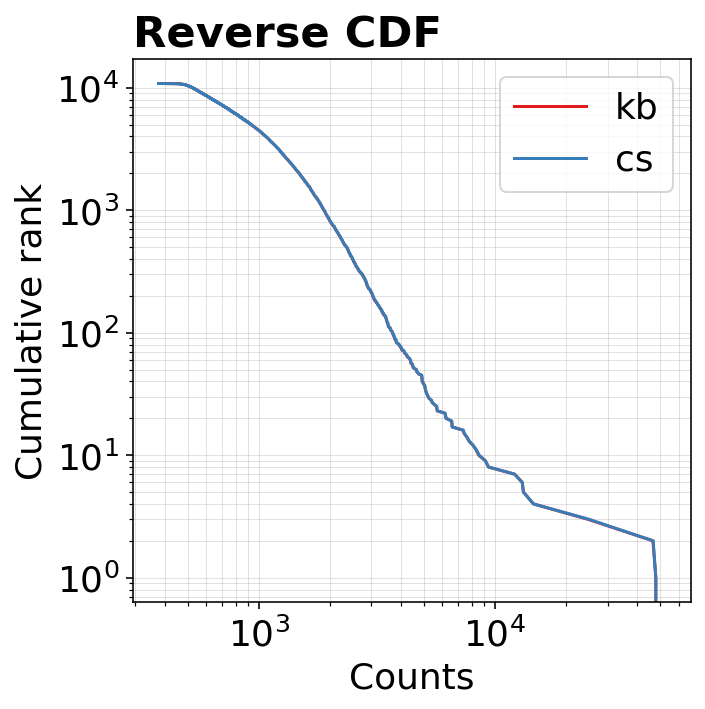

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

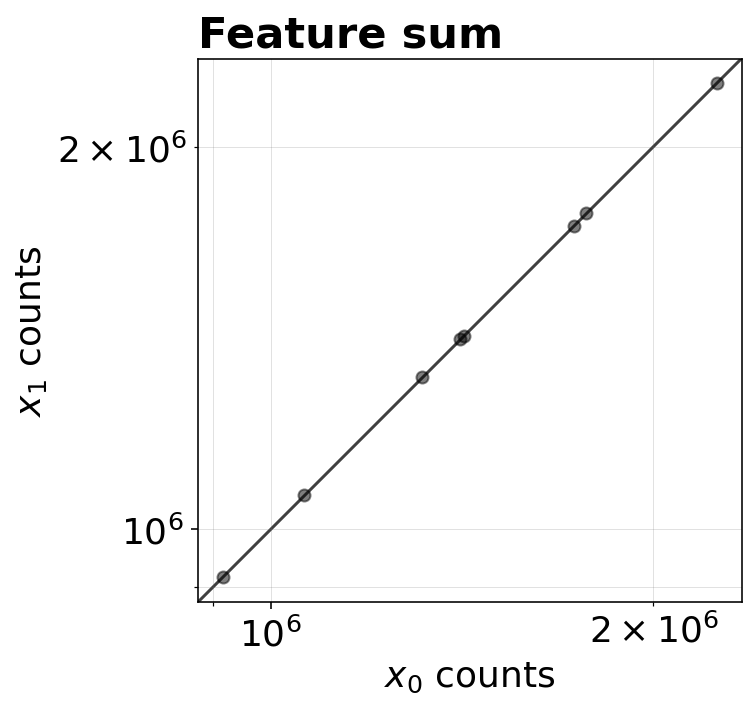

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

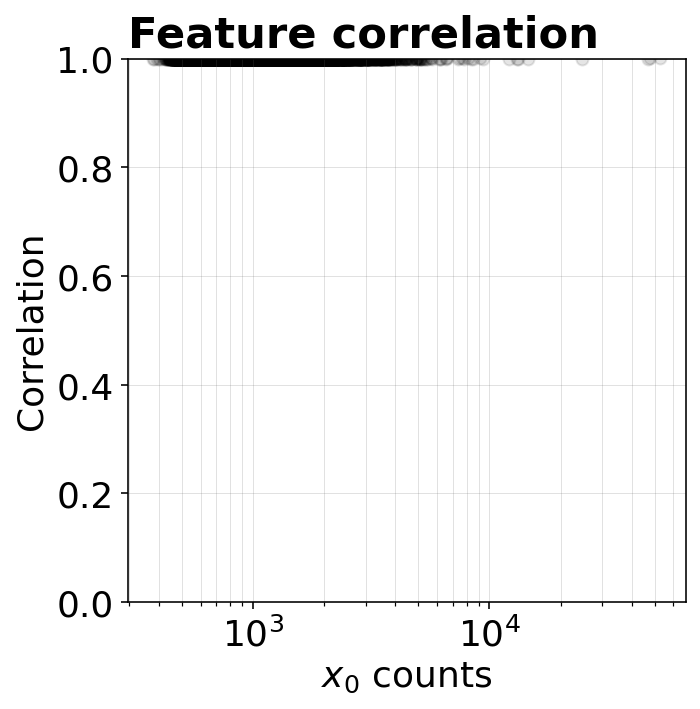

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [21]:
XX_XY = compare.l1_distance(kb.X, cs.X)
YY_YX = compare.l1_distance(cs.X, kb.X)

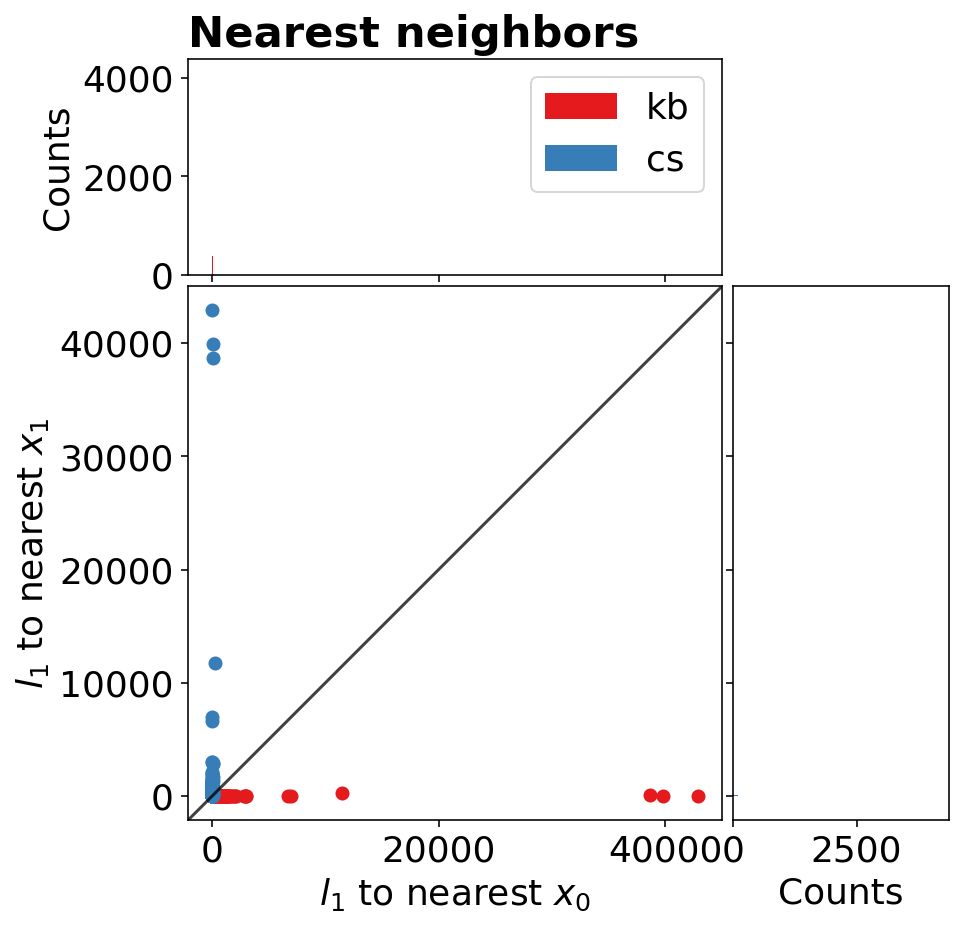

In [22]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [23]:
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

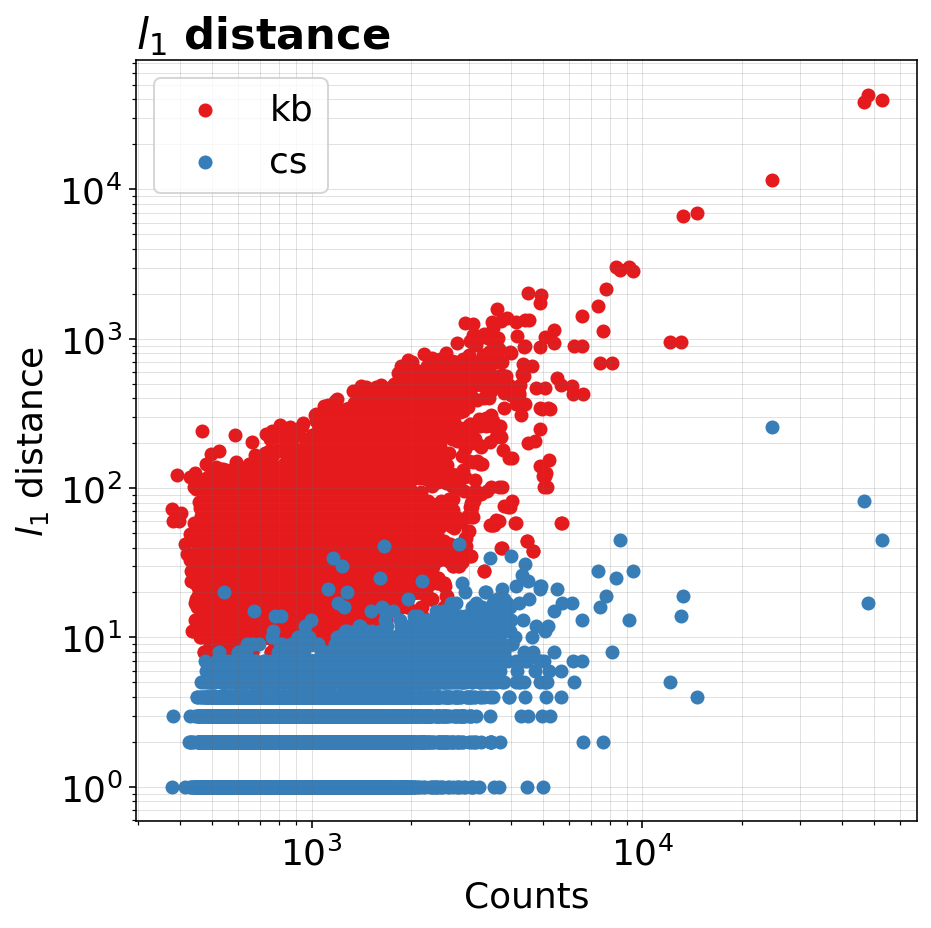

In [24]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)

fig.show()

----------------------------------------

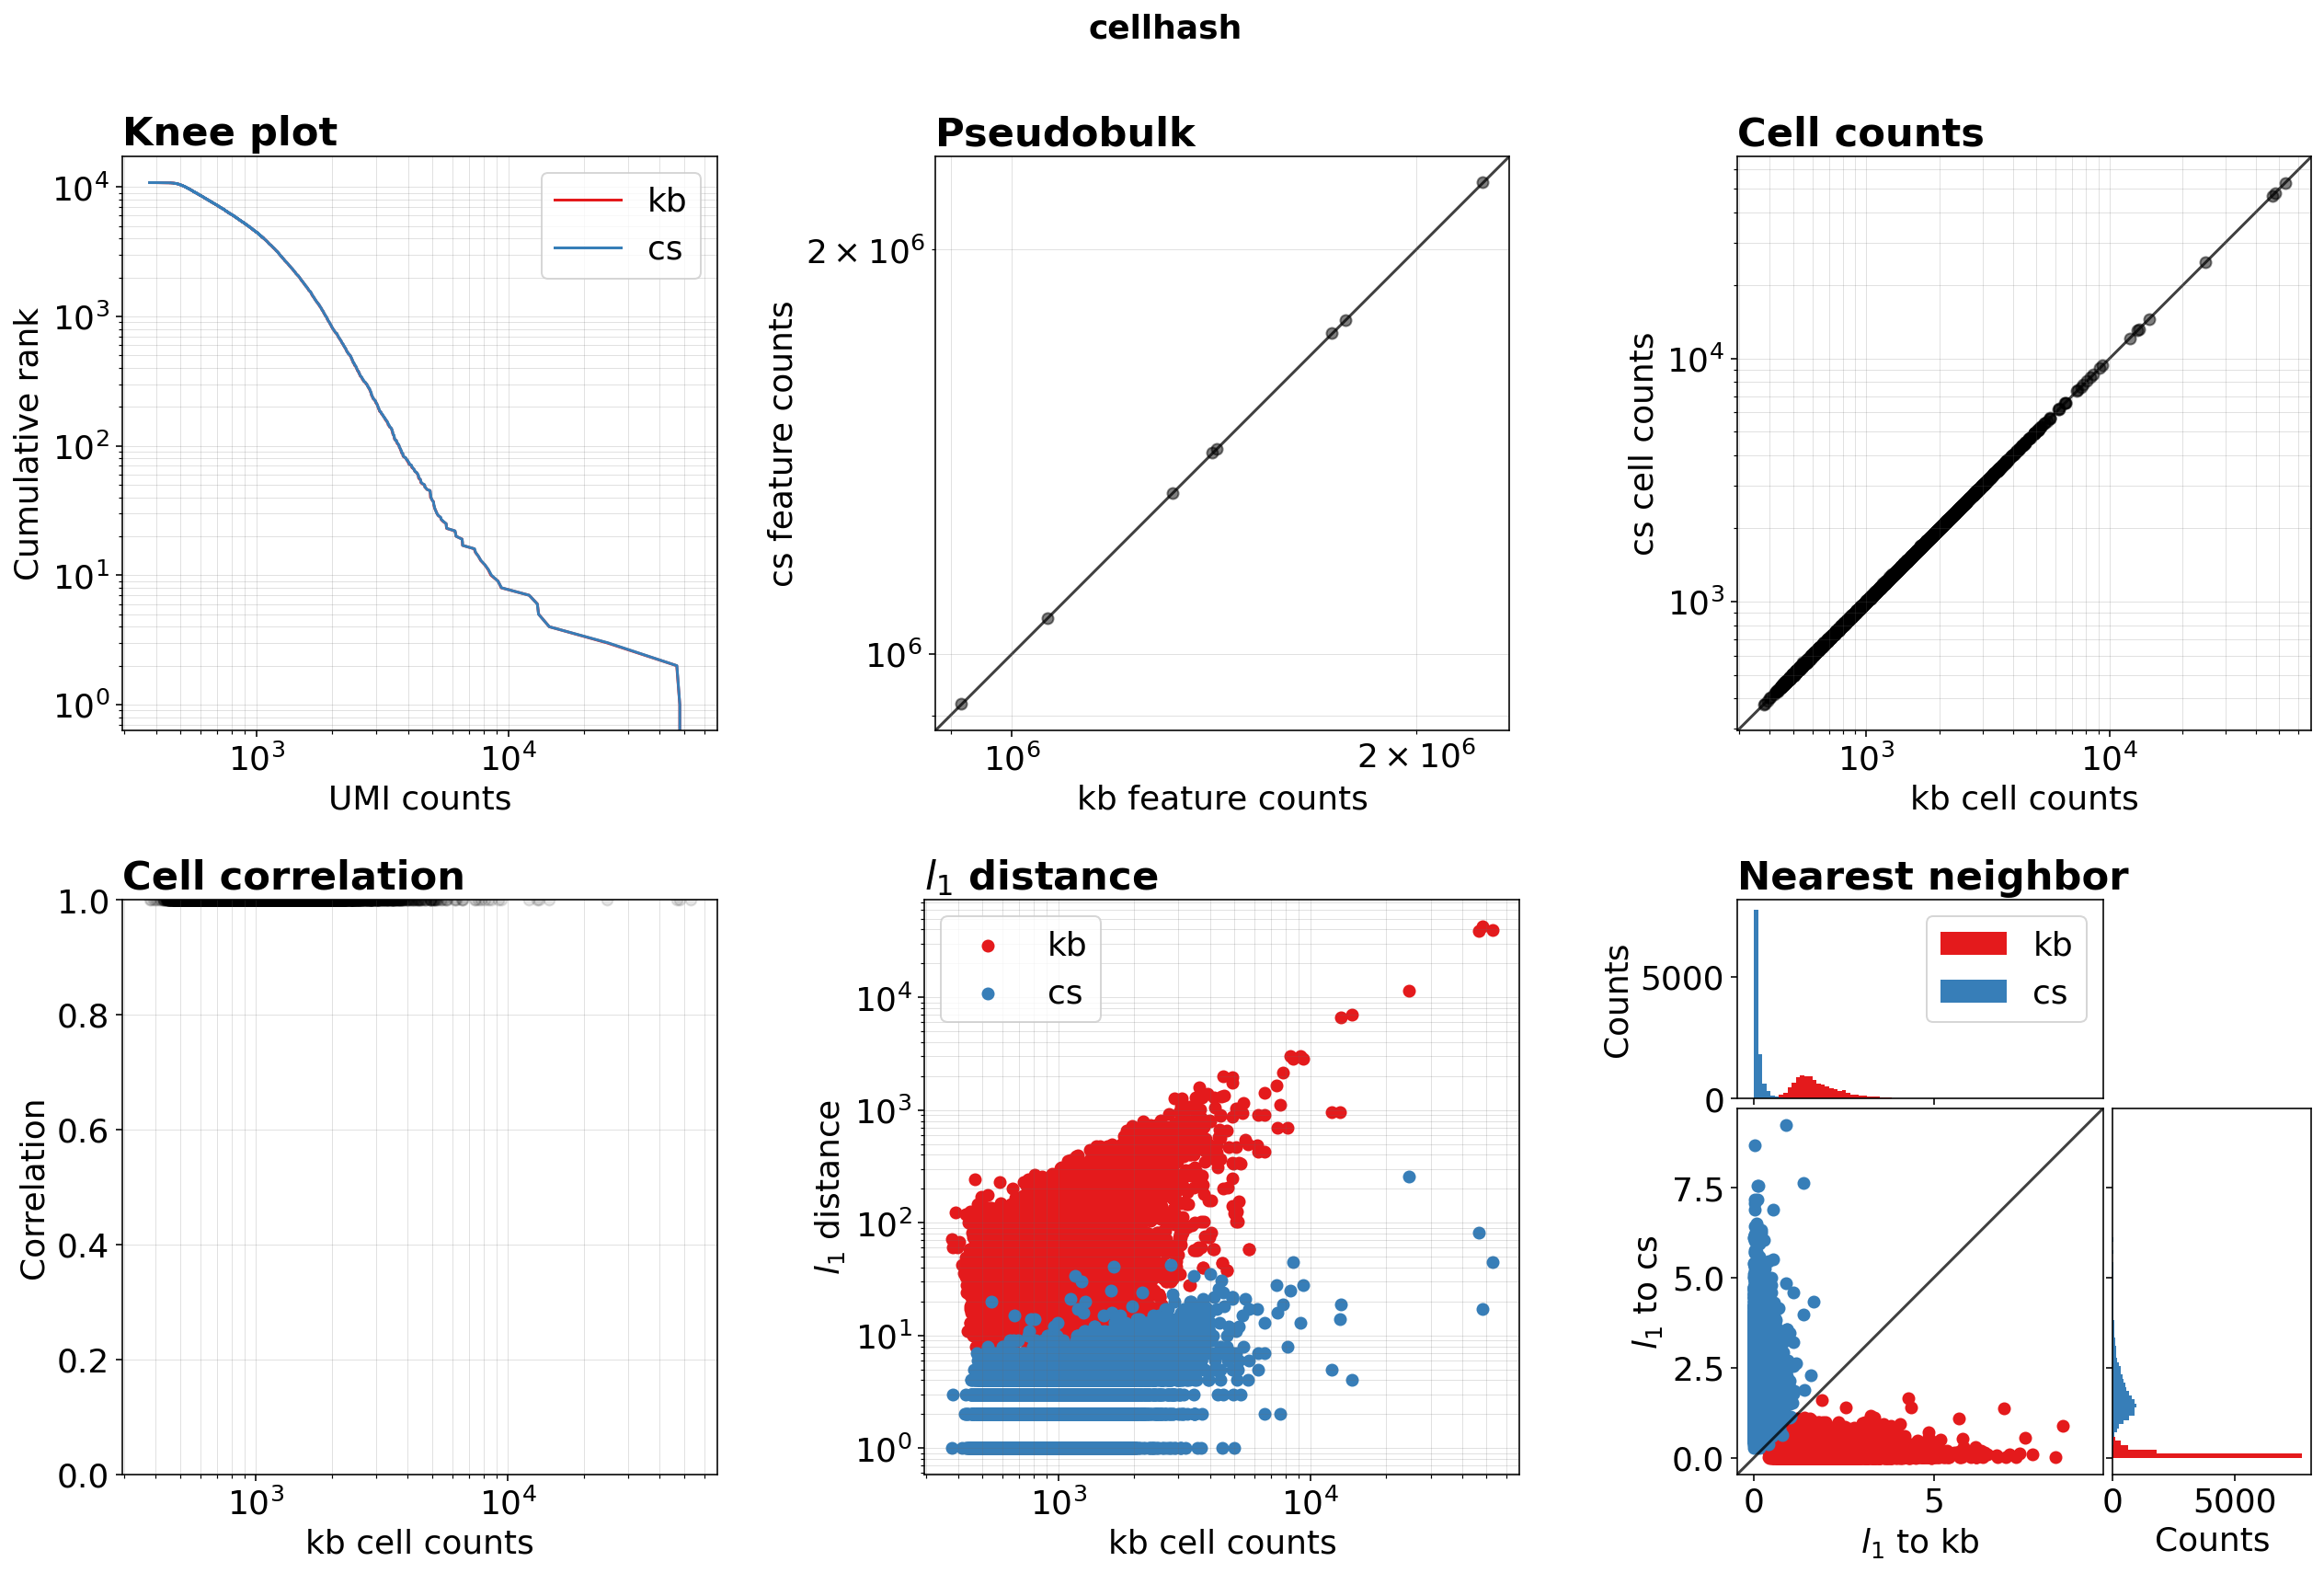

In [25]:

# Putting everything into one figure
row, col = (2, 3)
scale = 6

ds_name = "cellhash"

fig, axs = plt.subplots(figsize=(col*scale, row*scale), nrows=row, ncols=col)
fig.suptitle(ds_name, fontweight='bold', fontsize = fsize, x=0.5, y=0.999)

# knee plot
ax = axs[0,0]

title = "a"
x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors, xlabel="UMI counts", title="Knee plot")

for line in ax.lines:
    line.set_linewidth(5.)

# pseudobulk
ax = axs[0,1]

title = "b"
x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} feature counts", ylabel=f"{labels[1]} feature counts", title="Pseudobulk")
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# cell counts
ax = axs[0,2]

title = "c"
x0, x1 = compare.cmp_sum(kb.X, cs.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} cell counts", ylabel=f"{labels[1]} cell counts", title="Cell counts")


# features correlated
ax = axs[1,0]

title = "d"
x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax, xlabel=f"{labels[0]} cell counts", title="Cell correlation")

# l1 counts
ax = axs[1,1]

title = "e"
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

plot.l1_counts((cnts, XX), (cnts, XY), 
   ax=ax, 
   colors=colors,
   labels=labels,
   xlabel=f"{labels[0]} cell counts")

# nearest neighbor
ax = axs[1,2]

title = "f"
# note, taking log1p here
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cs.X))
YY_YX = compare.l1_distance(np.log1p(cs.X), np.log1p(kb.X))
plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                 ax=ax, 
                 labels=labels, 
                 colors=colors,
                 xlabel=f"$l_1$ to {labels[0]}",
                 ylabel=f"$l_1$ to {labels[1]}",
                 title="Nearest neighbor")

fig.tight_layout()
fig.savefig(f"{ds_name}.png", dpi=300, bbox_inches="tight")
fig.show()